在这类，我们先接触一些NLP常用的提供一些基础功能的库。

拼写纠错是自然语言处理中一项基础任务，大量应用于信息检索，输入法等。  

按照错误类型的不同可分为两种：  

拼写词本身不合法 oov（out of vocabulary）如：将girl 写为gril  
拼写错误的词属于合法词 如：将think 写为thank  

本文主要解决的为第一种拼写错误。  

任务分为两大部分：

1. 统计新闻语料，获取纠错任务中需要的统计值
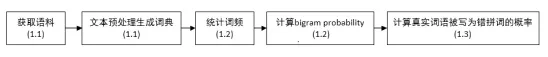

2. 对于给定输入为拼写错误的文本，进行纠错  
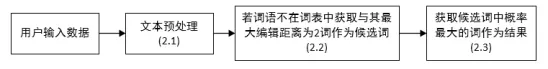

### 任务流程详解及代码  
#### 1.  获取统计值  
##### 1.1  语料预处理  
获取文本语料。本文选取了nltk中路透社的新闻语料，在每个句子的起始和结束位置分别添加符号"\<s\>","\<\/s\>"，将词语转换为小写。

**nltk.corpus** 是 Natural Language Toolkit（NLTK）库中的一个重要部分，它提供了对大量语料库的访问，以便进行自然语言处理（NLP）。NLTK 是用于人工智能和计算语言学领域的一个流行的 Python 工具包。nltk.corpus 包含多种语料库，这些语料库包含不同类型的文本和标注数据，可以用于任务如词性标注、命名实体识别、句法分析等。  

以下是一些常用的 nltk.corpus 库中包含的语料库：  

- Brown Corpus: 一个综合性的语料库，包含不同风格和领域的文本。它常用于测试NLP算法的通用性。
- Gutenberg Corpus: 包含一系列从Project Gutenberg下载的书籍文本，适合进行文学分析。
- WordNet: 一个英语词汇数据库，非常适合进行单词意义的比较和单词关系的研究。
- Treebank Corpus: 包括详细的句法分析树，通常用于训练和测试句法分析器。
- Stopwords: 包含多种语言的常用停用词列表，常用于文本预处理阶段，以去除可能影响分析的常见但无关紧要的单词。
使用这些语料库前，你通常需要使用 nltk.download() 方法来下载特定的语料库数据。例如，要下载并使用停用词列表，你可以这样做：  
nltk.download(“Stopwords”) 


In [8]:
import numpy as np
import collections
import nltk
from nltk.corpus import reuters

nltk.download('reuters')

# 获取 Reuters 语料库中的所有类别（或主题）。Reuters 语料库的文档通常被分类为多个主题类别，如 "grain", "wheat", "corn" 等。
categories = reuters.categories()
print("Categories:", len(categories))

# 使用 sents() 方法加载特定类别的所有句子。这里通过指定 categories=categories 参数，表示加载所有类别的句子。
corpus = reuters.sents(categories=categories)
print("corpus:", len(corpus))

# 在每个句子的起始和结束位置分别添加符号"<s>","</s>"，将词语转换为小写。
sentences = [ ["<s>"] + s + ["</s>"] for s in corpus]
print("sentences:", len(sentences))

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Autin\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


Categories: 90
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']
corpus: 54716
sentences: 54716


In [11]:
word2idx = collections.defaultdict(int)
idx2word = collections.defaultdict(str)
i = 0
# 建立单词表和索引表
for sen in sentences:
    for word in sen:
        if word.lower() not in word2idx:
            word = word.lower()
            word2idx[word] = i
            idx2word[i] = word
            i += 1
vocab_size = len(word2idx)

# 创建一个一维数组 word_count，其长度等于词汇表的大小（vocab_size）。数组中的每个元素都初始化为 0。
word_count = np.zeros(vocab_size)

# 创建了一个二维数组 bigram_count，其尺寸为 vocab_size x vocab_size。
# 数组有 vocab_size 行和 vocab_size 列，数组的每个元素也被初始化为 0。
bigram_count = np.zeros((vocab_size, vocab_size))


# 统计词频
for text in sentences:
    for i in range(len(text) - 1):
        word = text[i].lower()
        next_word = text[i+1].lower()
        word_count[word2idx[word]] += 1
        bigram_count[word2idx[word],word2idx[next_word]] += 1
    word_count[word2idx[text[-1].lower()]] += 1
    
# 创建了一个二维数组 bigram_prob，其尺寸为 vocab_size x vocab_size。
# 数组有 vocab_size 行和 vocab_size 列，数组的每个元素也被初始化为 0。
bigram_prob = np.zeros((vocab_size, vocab_size))

import time   # 这个time就是显示一下时间，和算法没关系
for i in range(vocab_size):
    before_time = time.time()
    for j in range(vocab_size):
        bigram_prob[i,j] = (bigram_count[i,j] + 1.0) / (word_count[i] + vocab_size)
    if i % 1000 == 0:
        after_time = time.time()
        print("done: "  + str(i) + "  pass time: " + str(after_time - before_time))
        before_time = time.time()
print("Done!")

done: 0  pass time: 0.018550395965576172
done: 1000  pass time: 0.025510072708129883
done: 2000  pass time: 0.012205362319946289
done: 3000  pass time: 0.025692224502563477
done: 4000  pass time: 0.01629185676574707
done: 5000  pass time: 0.01610422134399414
done: 6000  pass time: 0.01712775230407715
done: 7000  pass time: 0.02291131019592285
done: 8000  pass time: 0.01981806755065918
done: 9000  pass time: 0.020859956741333008
done: 10000  pass time: 0.02207493782043457
done: 11000  pass time: 0.019965171813964844
done: 12000  pass time: 0.020742177963256836
done: 13000  pass time: 0.023744821548461914
done: 14000  pass time: 0.01700592041015625
done: 15000  pass time: 0.01855015754699707
done: 16000  pass time: 0.020027637481689453
done: 17000  pass time: 0.020817041397094727
done: 18000  pass time: 0.01990342140197754
done: 19000  pass time: 0.019643068313598633
done: 20000  pass time: 0.019884586334228516
done: 21000  pass time: 0.02050495147705078
done: 22000  pass time: 0.0256061

In [29]:

channel = collections.defaultdict(dict)

wrong_word_list = collections.defaultdict(int)

# 计算channel probability
# 这里spell-errors.txt是一个可能拼错的单词表，就是单词A，可能被拼错成那几个其他不同的形式
for line in open('spell-errors.txt'):
    words = line.strip().lower().split(":")
    correct_word = words[0]
    wrong_words = words[1].split(",")
    count = 0.0
    error_prob = collections.defaultdict(float)
    for word in wrong_words:
        word = word.strip()
        if word not in wrong_word_list:
            wrong_word_list[word] = 1
        else: 
            wrong_word_list[word] += 1
        num = 1
        if "*" in word:
            num = int(word.split("*")[1])
            word = word.split("*")[0]
        count += num
        error_prob[word] = num
    error_prob = {k:v/count for k, v in error_prob.items()}
    channel[correct_word] = error_prob
'''    
for word in wrong_word_list:
    if wrong_word_list[word]>1:
        print(word)
        
print(channel['look'])
'''

for*4
haing
look*2
louk
shoudln
prise
wensday
wedensday
pluse
increase
insest
dael
hiar
hare
hir
hair
her
hes
there
three
har
head
hera
heir
heat
he
heer
hire
thehe
hon
eate
atom
controveries
cancelation
criticise
sinse
explane
expent
exple
strick
heart
hod
lock
cortion
wont
what
mant
wand
woth
went
wat
how
ho
damadge
damge
damage
dammage
moter
hou
aht
hat
hope
long
rog
ro
erally
snow_ball
wid
misdemenor
misdameanor
fur
fite
fid
seceed
labatory
lab
wip
niet
nit
et
ete
todays
wosh
basket-ball
servise
lesson
tee
commet
phnumonia
pheumonia
amonia
idel
ide
lot
coururier
shale
sall
she
moth
scem
bown
book
gape
garge
gang
gams
gar
grage
cage
then
that
tost
toght
tuch
lade
ladys
plat
poket
fare
be
dest
bass
beat
mest
bes
bet
lost
sied
se
nef
ner
dept
deat
and
cout
vane
critisized
must
mach
privilages
frie
lif
lief
live
wich
wis
left
work
workt
spen
careing
sech
employe
viste
vist
paly
play
anticapate
antisepate
anticapting
anticipate
dam
think*2
babe
marrid
finally
finially
previos
ad
han
hed

In [33]:
# 这里使用在单词中替换和插入字母来生成可能的candidate
def generate_candidates_helper(word):
    chars = "abcdefghijklmnopqrstuvwxyz"
    words = set()
    #insert
    words = set(word[0:i] + chars[j] + word[i:] for i in range(len(word)) for j in range(len(chars)))
    #replace
    words = words | set(word[0:i] + chars[j] + word[i+1:] for i in range(len(word)) for j in range(len(chars)))
    #remove
    words = words | set(word[0:i] + word[i+1:] for i in range(len(word)))
    # get valid words
    words = set(transfer_word for transfer_word in words if transfer_word in word2idx and transfer_word != word)
    return words

# 设置Candidate的距离是2，就是可能插入或替换2个字母
def generate_candidates(word):
    # Get words with distance of 1
    dis1_words = generate_candidates_helper(word)
    dis2_words = set()
    # Get words with distance of 2
    for dis1_word in dis1_words:
        dis2_words = dis2_words | generate_candidates_helper(dis1_word)
    return dis1_words | dis2_words

# 根据前一词和后一词推断这个词.
# 
def word_correct(word, context):
    candidates = generate_candidates(word)
    print(candidates)
    correct_word = word
    max_prob = float("-inf")
    for candidate in candidates:
        prob = float("-inf")
        # 这里的判断条件比较苛刻，首先按照距离2生成的candidates列表，这个candidate是要在word2idx存在的单词
        # 然后这个单词要在channel的正确拼写单词中（现在只有7000多个单词），然后在这个channel的单词对应的
        # 错误拼写要有当前查询的拼写错的单词。所以下面的代码理论上是可以在匹配到的多个candidate中返回一个
        # 最合适的。但是基于现在的数据，能匹配到一个就已经不错了。
        if candidate in word2idx and candidate in channel and word in channel[candidate]:
            print(candidate)
            prob = np.log(channel[candidate][word])
            if context[0] in word2idx:
                prob += np.log(bigram_prob[word2idx[context[0]],word2idx[candidate]])
            if context[1] in word2idx:
                prob += np.log(bigram_prob[word2idx[candidate],word2idx[context[1]]])
        if max_prob < prob:
            max_prob = prob
            correct_word = candidate
    return correct_word

# 对于每一句（一行）进行拼写检查
def spell_corrector(line):
    line = ["<s>"] + line.strip().lower().split(" ") + ["</s>"]
    newline = []
    for i in range(1, len(line)-1):
        word = line[i]
        # 这个单词不在word2idx表中，认为是拼写错误
        if word not in word2idx:
            # 判断单词不在单词表中
            next_word = line[i+1]
            pre_word = line[i-1]
            word = word_correct(word, (pre_word, next_word))
        newline.append(word)
    newline = " ".join(newline)
    return newline
 
test_query1 = "When did you strat dancing"  
test_query2 = "What counted for more of the poplation change"
#test_query3 = "She is louk at the flower"
test_query1 = spell_corrector(test_query1)
test_query2 = spell_corrector(test_query2)
#test_query3 = spell_corrector(test_query3)
print(test_query1) # 正确结果为 when did you start dancing
print(test_query2) # 正确结果为 what counted for more of the popul
#print(test_query3) # 正确结果为 what counted for more of the popul


{'stora', 'sat', 'sgat', 'stad', 'seat', 'snat', 'stant', 'scat', 'tcat', 'stay', 'start', 'stas', 'strb', 'trak', 'tat', 'istat', 'staf', 'straw', 'slat', 'stry', 'tran', 'that', 'strain', 'strait', 'star', 'stra', 'strl', 'tract', 'surat', 'xtra', 'sra', 'astra', 'prat', 'traf', 'stna', 'str', 'sara', 'stat', 'stan', 'trat', 'treat', 'strw', 'stet', 'sta'}
start
{'population'}
population
when did you start dancing
what counted for more of the population change
